# DenseNet

## 稠密块体

In [1]:
import torch
from torch import nn 
import sys
sys.path.append(r"../")
import mytorch

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()

        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels * i +input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X
    
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## 过渡层

In [2]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## DenseNet 模型

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

## 训练模型

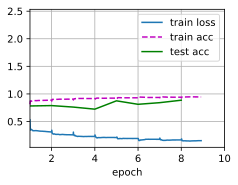

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = mytorch.load_data_fashion_mnist(batch_size, resize=96)
mytorch.train_ch6(net, train_iter, test_iter, num_epochs, lr, mytorch.try_gpu())